# Runge–Kutta

I show here how the Runge–Kutta method works. I'll implement a general
RK solver, in which one can give the parameters of *any* stage method
and run it. For the moment I only have Euler and RK4, but tI think
I have made the implementation easy enough to add others as well.


The explicit Runge–Kutta (RK) method is basically a higher order extension of the Euler one.
The Euler method is an iterative method, where the next step is obtaind by keeping the
first order in the Taylor series

$$
\vec{y}(t+\delta t)=\vec{y}(t)+\vec{y}'(t)\delta t + \dfrac{1}{2}\vec{y}''(t)\delta t ^2 +...
$$

Having a differential equation
$$
\dfrac{d\vec{y}}{dt}=f(\vec{y},t) \;,
$$
with  given $\vec{y}(0)$ (I always transform t to be in $[0,1]$), the general 
(s-stage) explicit Runge–Kutta itaration is[$^1$](#footnote1)


$$
\vec{y}_{n+1}=\vec{y}_{n}+ h\sum_{i=1}^{s} b_i \vec{k}_i \;,
$$
with

$$
\vec{k}_{1}=f(\vec{y}_n,t_n) \\
\vec{k}_{2}=f\Bigg(\vec{y}_n +h(a_{21} \vec{k}_{1}),t_n+c_{2} h \Bigg) \\
\vdots \\
\vec{k}_{s}=f\Bigg(\vec{y}_{n}+h \Big(\sum_{i=1}^{s-1}a_{s,i}\vec{k}_{i} \Big), t_{n}+h c_{s}   \Bigg)\;.
$$


We can then use taylor expansion to find all $a$, $b$ and $c$, but the a lot of RKs have been tabulated 
in Butcher tableaux

$$
\begin{array}{c|cccc}
c_1    & a_{11} & a_{12}& \dots & a_{1s}\\
c_2    & a_{21} & a_{22}& \dots & a_{2s}\\
\vdots & \vdots & \vdots& \ddots& \vdots\\
c_s    & a_{s1} & a_{s2}& \dots & a_{ss} \\
\hline
       & b_1    & b_2   & \dots & b_s
\end{array}
$$

Note that for explicit RK methods, the upper triangle including the diagonal of $a$ is zero.


$$\begin{array}{}
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
\hline
\end{array}$$ 
<span id="footnote1">$^1$<font size="-1"> Note that stage and order are not the same.</font></span>

For example the RK4, ie a 4-stage Runge–Kutta, is defined by
$$
\begin{matrix}
c_1=0 & c_2=1/2 & c_3=1/2 & c_4 =1 \\
b_1=1/6 & b_2=1/3 & b_3=1/3 & b_4 =1/6 
\end{matrix}
$$

$$
a_{ij}=\left(  
\begin{matrix}
0 & 0 & 0 & 0  \\
1/2 & 0 & 0 & 0  \\
0 & 1/2 & 0 & 0  \\
0 & 0 & 1 & 0  
\end{matrix}
\right)
$$

In the form of a Butcher tableau

\begin{array}{c|cccc}
0   & 0   & 0   & 0   & 0\\
1/2 & 1/2 & 0   & 0   & 0\\
1/2 & 0   & 1/2 & 0   & 0\\
1   & 0   & 0   & 1   & 0\\
\hline
    & 1/6 & 1/3 & 1/3 & 1/6\\
\end{array}

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=10
plt.rcParams['mathtext.fontset']='stixsans'

In [2]:
#define RK4 parameters
class RK4:
    def __init__(self):
        #these are used by the RK class
        self.s=4
        self.c=[0,0.5,0.5,1.]
        self.b=[1/6.,1/3.,1/3.,1/6.]
        self.a=[ [0 for j in range(4)] for i in range(4)]
        self.a[1][0]=0.5
        self.a[2][1]=0.5
        self.a[3][2]=1.
        #you can have other attributes for error estimation
        #or to keep track of different things you want.
        
        
        
rk4=RK4()

#define Euler parameters
class euler:
    def __init__(self):
        self.s=1
        self.c=[0]
        self.b=[1]
        self.a=[ [0 for j in range(1)] for i in range(1)]
        
eu=euler()


In [3]:
class exRK:
    '''
    This is a general implementation of explicit RK solver of
    a system of differential equations in the interval [0,1].
    
    Inputs:
    n_eqs=number of equations to solve
    
    diffeq=an object with dydt(y,t) method, which is 
           the system of dufferential equations to solve
    
    init_cond= the initial consitions 
    
    N=number of steps (ie fixed stepsize)
    
    RK_method= an object with attributes s (stage), and Butcher a,b,c parameters, 
               which define the method. 
               
        
        
    The solutions (list of \vec{y}_{n}) are stored in self.solution 
    and the steps in self.steps.
               
    Example:
    #define RK4
    class RK4:
        def __init__(self):
            self.s=4
            self.c=[0,0.5,0.5,1]
            self.b=[1/6.,1/3.,1/3.,1/6.]
            self.a=[ [0 for j in range(4)] for i in range(4)]
            self.a[1][0]=0.5
            self.a[2][1]=0.5
            self.a[3][2]=1.

    rk4=RK4()#make an instance of RK4
               
    #define the system to solve
    class diff_eq:
        def __init__(self,n=1):
            self.n_eqs=n #you call this from the solver (instead of passing it as a argument to the solver)
        def dydt(self,y,t):
        return [(-y[0]**2+y[1]**2)*2,(-y[1]**2+y[0]**2)*2]
        
    dydt=diff_eq(2)#make an instance of the system
        
    sol1=exRK(dydt,[1,0.5],50)#initialize the solver
    
    sol1.solve()#solve the system!
    
    '''
    
    def __init__(self,diffeq,init_cond,N,RK_method):
        self.step_number=N
        self.step_size=1./(N-1)#constant step size.
        self.dydt=diffeq#the differential equation to be integrated
        self.number_of_eqs=diffeq.n_eqs#number of equations
        
        self.steps=[0 for i in range(N)]#list of steps, ie t
        
        #initiate list of solutions for every t, ie y^(i)_{n}
        self.solution=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i]=[0 for i in range(N)]
            
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i][0]=init_cond[eq_i]#the first step is the initial condition
        
        self.current_step=0#initiate a counter (when this becomes equal to N, the solver terminates)
        
        self.end=False# to be changed to True when self.current_step=N
        
        #get the parameters that define the method
        self.s=RK_method.s
        self.a=RK_method.a
        self.b=RK_method.b
        self.c=RK_method.c
        
        
        self.yn=[0 for i in range(self.number_of_eqs)]#this is initiated to hold current steps
        
        self.k=[0 for i in range(self.number_of_eqs)]#this is initiated to hold all ks
        for eq_i in range(self.number_of_eqs):
            self.k[eq_i]=[0 for i in range(self.s)]
        
        
    # function to calculate the \sum_{i=1}^{current stage-1} a_{current stage,i} \vec{k}_{i}*step_size
    def sum_ak(self,stage):
        ak=[0 for i in range(self.number_of_eqs)]
        
        for eq_i in range(self.number_of_eqs):
            for i in range(stage-1):
                ak[eq_i]+=self.a[stage][i]*self.k[eq_i][i]*self.step_size
        
        return ak
    
    # function to calculate the \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
    def sum_bk(self):
        bk=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            for i in range(self.s):
                bk[eq_i]+=self.b[i]*self.k[eq_i][i]*self.step_size
        return bk

    def next_step(self):
        '''
        Get the next step.
        '''
        if self.current_step>=self.step_number-1:
            self.end=True 
        else:
            self.current_step+=1
            tn=self.current_step*self.step_size
            self.steps[self.current_step]=tn
            
            #define a list which holds previous point (makes the code slower, but more transparent) 
            for eq_i in range(self.number_of_eqs):
                self.yn[eq_i]=self.solution[eq_i][self.current_step-1]
    
            #this is \vec{k}_1.  
            for eq_i in range(self.number_of_eqs):
                self.k[eq_i][0]=self.dydt(self.yn,tn)[eq_i]
            
            #once you have \vec{k}_1, find the others.
            for stage in range(1,self.s):
                #since \sum_{i=1}^{s} a_{stage,i} \vec{k}_{i}*step_size is the same for all 
                #equations in a given stage, call here self.sum_ak
                _ak=self.sum_ak(stage)
                
                #get a d\vec{y}/dt needed for \vec_{k}_{stage}
                _dydt=self.dydt(  [self.yn[_eq]+_ak[_eq] for _eq in range(self.number_of_eqs)] ,
                                tn+self.c[stage]*self.step_size )
                for eq_i in range(self.number_of_eqs):
                    self.k[eq_i][stage]=_dydt[eq_i]
                    
            
            #calculate \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
            _bk=self.sum_bk()
            for eq_i in range(self.number_of_eqs):
                #calculate \vec{y}_{n+1}=\vec{y}_{n}+\sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
                self.solution[eq_i][self.current_step]=self.yn[eq_i]+_bk[eq_i]
                
            
                
            
    def solve(self):
        '''
        Run  next_step until self.end becomes True.
        '''
        while not self.end:
            self.next_step()

In [4]:
class diff_eq:
    def __init__(self,n=1):
        self.n_eqs=n
        
                   
    def __call__(self,y,t):
        return [-20*y[0]*t**3,
                5*y[0]*t**2+2*(-y[1]**2+y[2]**2)*t,  
                15*y[0]*t**2+2*(y[1]**2-y[2]**2)*t ]

    
dydt=diff_eq(3)

in0=[5,10,0]
sol1=exRK(dydt,in0,2000,RK_method=rk4)
sol2=exRK(dydt,in0,2000,RK_method=eu)

In [5]:
%%timeit -n 1 -r 1
sol1.solve()

76.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
%%timeit -n 1 -r 1
sol2.solve()

26.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


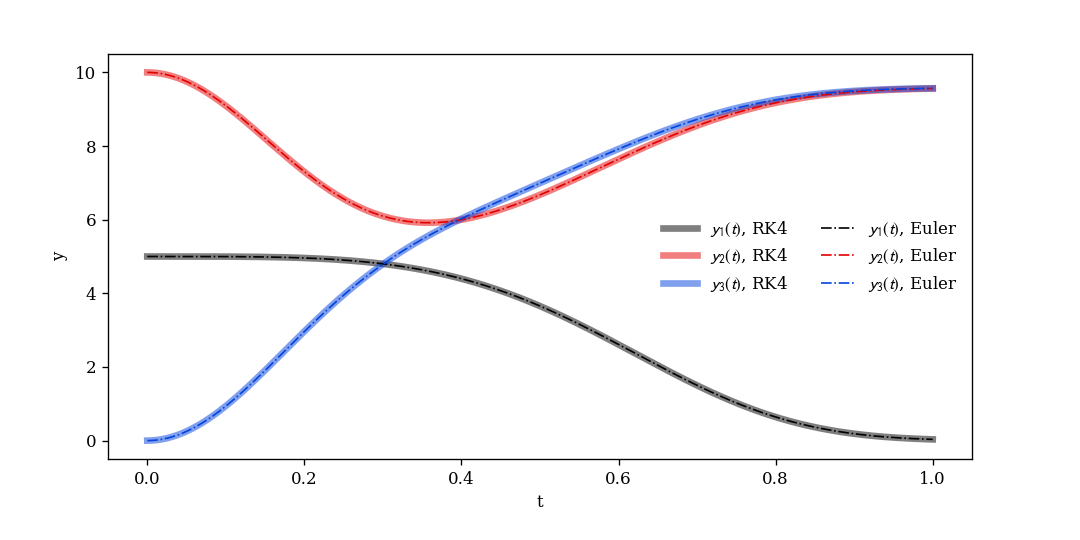

In [7]:
fig=plt.figure(figsize=(9,4.5))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(111)
for i in range(len(sol1.solution)):
    sub.plot(sol1.steps,sol1.solution[i],c=_c[i],alpha=0.5,linestyle='-',linewidth=4,label=r'$y_{'+str(i+1)+'}(t)$, RK4')
    
for i in range(len(sol2.solution)):
    sub.plot(sol2.steps,sol2.solution[i],c=_c[i],linestyle='-.',linewidth=1,label=r'$y_{'+str(i+1)+'}(t)$, Euler')

sub.set_ylabel('y')      
sub.set_xlabel('t')  
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,0.5))

plt.show()